In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import statsmodels.formula.api as smf
import statsmodels.api as sm # for the model family
from __future__ import division
%matplotlib inline


We'll use the Smarket data from the ISLR package in R. The data corresponds to S&P Stock market data. The response is the variable Direction. It denotes whether the market went up or down

In [17]:
smarkets = pd.read_csv('data/Smarket.csv')
smarkets.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


Let's start by looking at the data.

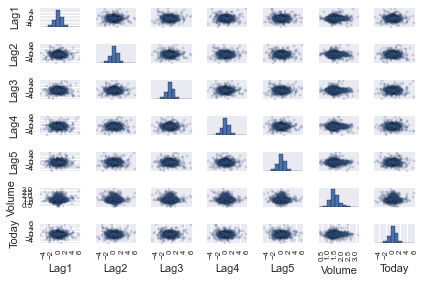

In [4]:
axes = pd.tools.plotting.scatter_matrix(smarkets.ix[:,1:], alpha = 0.2)
plt.tight_layout()
plt.savefig('pairs_smarket.pdf')

There are no obvious correlations in the data, which is expected in stock market data.
Let's try  fitting a logistic regression model.

In [18]:
logit_fit = smf.glm(formula = 'Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume',data = smarkets, family=sm.families.Binomial()).fit()

In [19]:
logit_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Generalized Linear Model Regression Results                           
================================================================================================
Dep. Variable:     ['Direction[Down]', 'Direction[Up]']   No. Observations:                 1250
Model:                                              GLM   Df Residuals:                     1243
Model Family:                                  Binomial   Df Model:                            6
Link Function:                                    logit   Scale:                             1.0
Method:                                            IRLS   Log-Likelihood:                -863.79
Date:                                  Tue, 22 Sep 2015   Deviance:                       1727.6
Time:                                          11:44:29   Pearson chi2:                 1.25e+03
No. Iterations:                                       6                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1260      0.241      0.523      0.601        -0.346     0.598
Lag1           0.0731      0.050      1.457      0.145        -0.025     0.171
Lag2           0.0423      0.050      0.845      0.398        -0.056     0.140
Lag3          -0.0111      0.050     -0.222      0.824        -0.109     0.087
Lag4          -0.0094      0.050     -0.187      0.851        -0.107     0.089
Lag5          -0.0103      0.050     -0.208      0.835        -0.107     0.087
Volume        -0.1354      0.158     -0.855      0.392        -0.446     0.175
==============================================================================
"""

None of the coefficients are significant. Let's turn the probability into predictions by thresholding them.

In [20]:
pred = logit_fit.predict()<0.5 # the model gives the prob. of the direction being "Down" (Dep. variable)
pred_str = np.array(['Up']*len(pred),dtype = 'S4') # it looks like S4 sets the maximum number of characters
pred_str[pred == False] = "Down"

Next, we make an error matrix (confusion matrix )

In [21]:
correct = smarkets.Direction ==  pred_str # boolean array where the predictions are correct
TN = sum(pred_str[correct] == "Up") # which of the correct predictions are "Up"
TP = sum(pred_str[correct] == "Down")
FN = sum(pred_str[-(correct)] == "Up")
FP = sum(pred_str[-correct] == "Down")
error_matrix = np.array([[TP,FN],[FP,TN]])
error_matrix

array([[145, 141],
       [457, 507]])

In [22]:
sum(correct)/len(smarkets)

0.52159999999999995

We do a little better than chance but this is the training error. We used all the data for this prediction. Instead, we can devide the data into training and testing. We'll train with all the data before 2005 and then test our model with the remaining data.

In [23]:
train_boolean = smarkets.Year < 2005
logit_fit_subset = smf.glm(formula = 'Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume',data = smarkets, subset = train_boolean, family=sm.families.Binomial()).fit()
logit_fit_subset.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Generalized Linear Model Regression Results                           
================================================================================================
Dep. Variable:     ['Direction[Down]', 'Direction[Up]']   No. Observations:                  998
Model:                                              GLM   Df Residuals:                      991
Model Family:                                  Binomial   Df Model:                            6
Link Function:                                    logit   Scale:                             1.0
Method:                                            IRLS   Log-Likelihood:                -690.55
Date:                                  Tue, 22 Sep 2015   Deviance:                       1381.1
Time:                                          11:44:51   Pearson chi2:                     998.
No. Iterations:                                       6                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.1912      0.334     -0.573      0.567        -0.845     0.463
Lag1           0.0542      0.052      1.046      0.295        -0.047     0.156
Lag2           0.0458      0.052      0.884      0.377        -0.056     0.147
Lag3          -0.0072      0.052     -0.139      0.889        -0.108     0.094
Lag4          -0.0064      0.052     -0.125      0.901        -0.108     0.095
Lag5           0.0042      0.051      0.083      0.934        -0.096     0.104
Volume         0.1163      0.240      0.485      0.628        -0.353     0.586
==============================================================================
"""

In [24]:
smarkets_test = smarkets[-train_boolean] # make a data frame with the test data
test_prob = logit_fit_subset.predict(smarkets_test)

In [27]:
pred_down = test_prob>0.5 # the model gives the prob. of the direction being "Down" (Dep. variable)
pred_str_test = np.array(['Down']*len(pred_down),dtype = 'S4') # it looks like S4 sets the maximum number of characters
pred_str_test[pred_down == False] = "Up"
correct = pred_str_test == smarkets_test.Direction
sum(correct)/len(smarkets_test.Direction)

0.48015873015873017

Our model does worse than chance in the test data. That's a sign that we are overfitting. Let's fit the model only with two features:

In [29]:
logit_fit_subset = smf.glm(formula = 'Direction~Lag1+Lag2',data = smarkets, subset = train_boolean, family=sm.families.Binomial()).fit()
print logit_fit_subset.summary()
test_prob = logit_fit_subset.predict(smarkets_test)
pred_down = test_prob>0.5 # the model gives the prob. of the direction being "Down" (Dep. variable)
pred_str_test = np.array(['Down']*len(pred_down),dtype = 'S4') # it looks like S4 sets the maximum number of characters
pred_str_test[pred_down == False] = "Up"
correct = pred_str_test == smarkets_test.Direction
sum(correct)/len(smarkets_test.Direction)

                          Generalized Linear Model Regression Results                           
Dep. Variable:     ['Direction[Down]', 'Direction[Up]']   No. Observations:                  998
Model:                                              GLM   Df Residuals:                      995
Model Family:                                  Binomial   Df Model:                            2
Link Function:                                    logit   Scale:                             1.0
Method:                                            IRLS   Log-Likelihood:                -690.70
Date:                                  Tue, 22 Sep 2015   Deviance:                       1381.4
Time:                                          11:45:59   Pearson chi2:                     998.
No. Iterations:                                       6                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------

0.55952380952380953

Now we do better than chance. But still no variable became significant.